In [33]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import numpy as np
import json

cudnn.benchmark = True
plt.ion()   # interactive mode

In [34]:
NUM_CLASSES = 102

## Load Data

In [35]:
# Cropping and normalization for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [36]:
# Data augmentation and normalization for training set
data_augmentation = transforms.Compose([
        transforms.RandomCrop(500),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [37]:
data_dir = '../Datasets/Kaggle/flower-data'
# A map with keys "train" and "val" and values being images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
augmented_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_augmentation)
image_datasets['train'] = torch.utils.data.ConcatDataset([image_datasets['train'], augmented_train_dataset])
# A map with keys "train" and "val" and values being DataLoaders. A DataLoader is an iterable. 
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].datasets[0].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Model

In [38]:
model_path = "saved-models/baseline_resnet18_10epochs_without_dataaugmentation.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Error Analysis

In [39]:
index_to_name_map = {}
with open("../Datasets/Kaggle/flower-data/index_to_name.json") as json_file:
    index_to_name_map = json.load(json_file)
ordered_flower_names = []
for key in sorted(index_to_name_map.keys()):
    ordered_flower_names.append(index_to_name_map[key])

In [40]:
# Make a matrix whose row represents true labels and column represents prediction labels
def create_prediction_matrix(model, dataset, num_images, batch_size):
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
    
    was_training = model.training
    model.eval()
    images_so_far = 0

    prediction_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES)).astype(int)

    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[dataset])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Iterate through predictions for one batch
            for j in range(inputs.size()[0]):
                prediction_matrix[labels[j]][preds[j]] += 1        
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return prediction_matrix
        model.train(mode=was_training)
        return prediction_matrix

In [41]:
prediction_matrix = create_prediction_matrix(model_ft, 'val', 900, 4)

205it [00:14, 14.17it/s]


In [42]:
def normalize_prediciton_matrix(prediction_matrix):
    normalized_prediction_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for j in range(NUM_CLASSES):
        column_sum = np.sum(prediction_matrix[:, j])
        if column_sum != 0:
            normalized_prediction_matrix[:, j] = prediction_matrix[:, j] / column_sum
    return np.around(normalized_prediction_matrix, decimals=1)

In [43]:
def visualize_matrix(matrix):
    plt.figure(figsize = (100, 100))
    plt.rcParams['figure.figsize'] = (50, 50)
    plt.matshow(matrix)
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.title("Prediction Results", fontsize=24)
    plt.xticks(ticks=np.arange(0, 102), labels=ordered_flower_names, rotation="vertical", fontsize=10)
    plt.yticks(ticks=np.arange(0, 102), labels=ordered_flower_names, fontsize=10)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("bottom")
    
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if matrix[i, j] != 0:
                text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black", fontsize=6)
    plt.tight_layout()
    plt.savefig("confusion_matrix.png") 
    plt.show()

<Figure size 7200x7200 with 0 Axes>

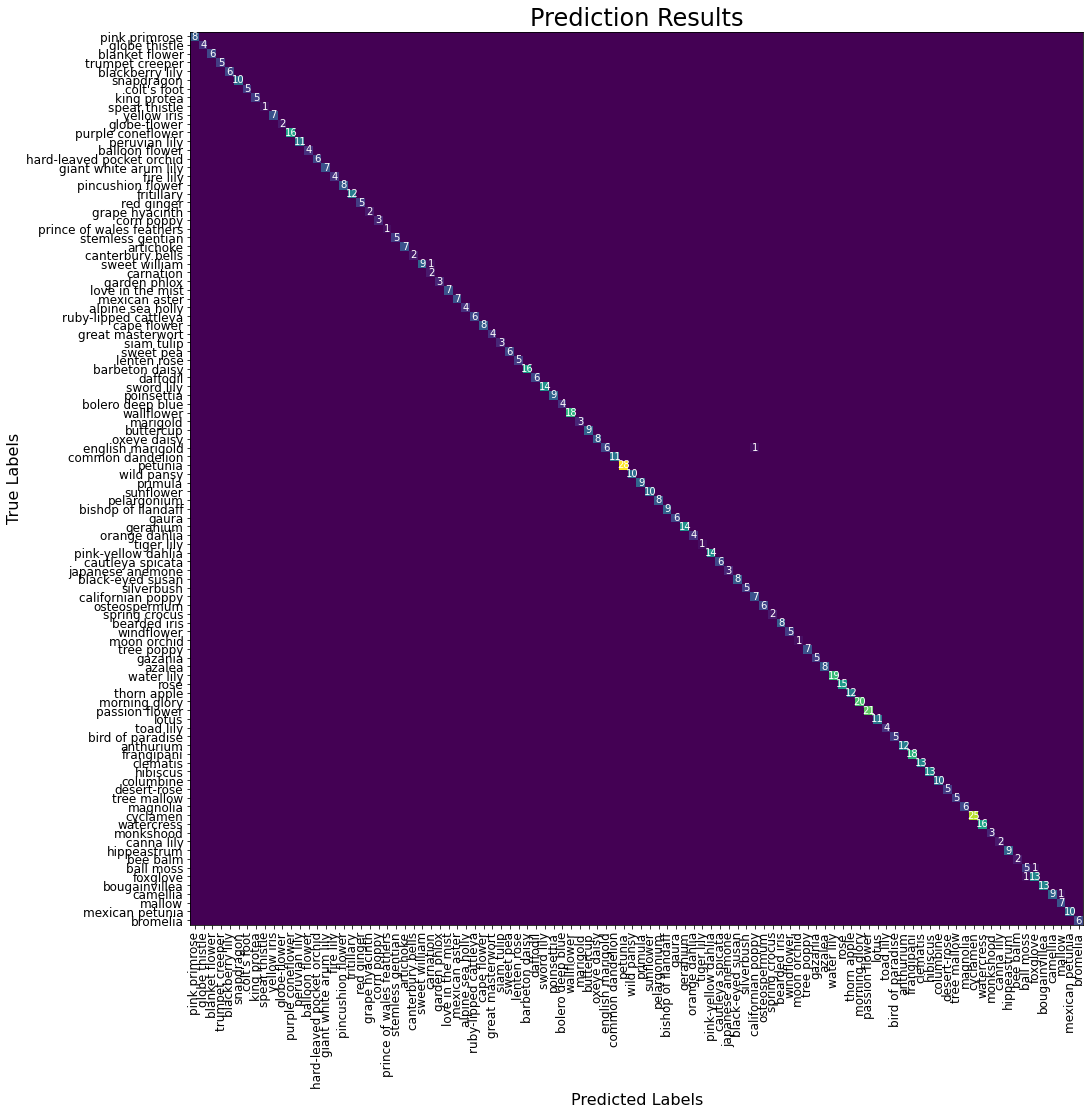

In [13]:
visualize_matrix(prediction_matrix)

/tmp/ipykernel_2978/1864557960.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 7200x7200 with 0 Axes>

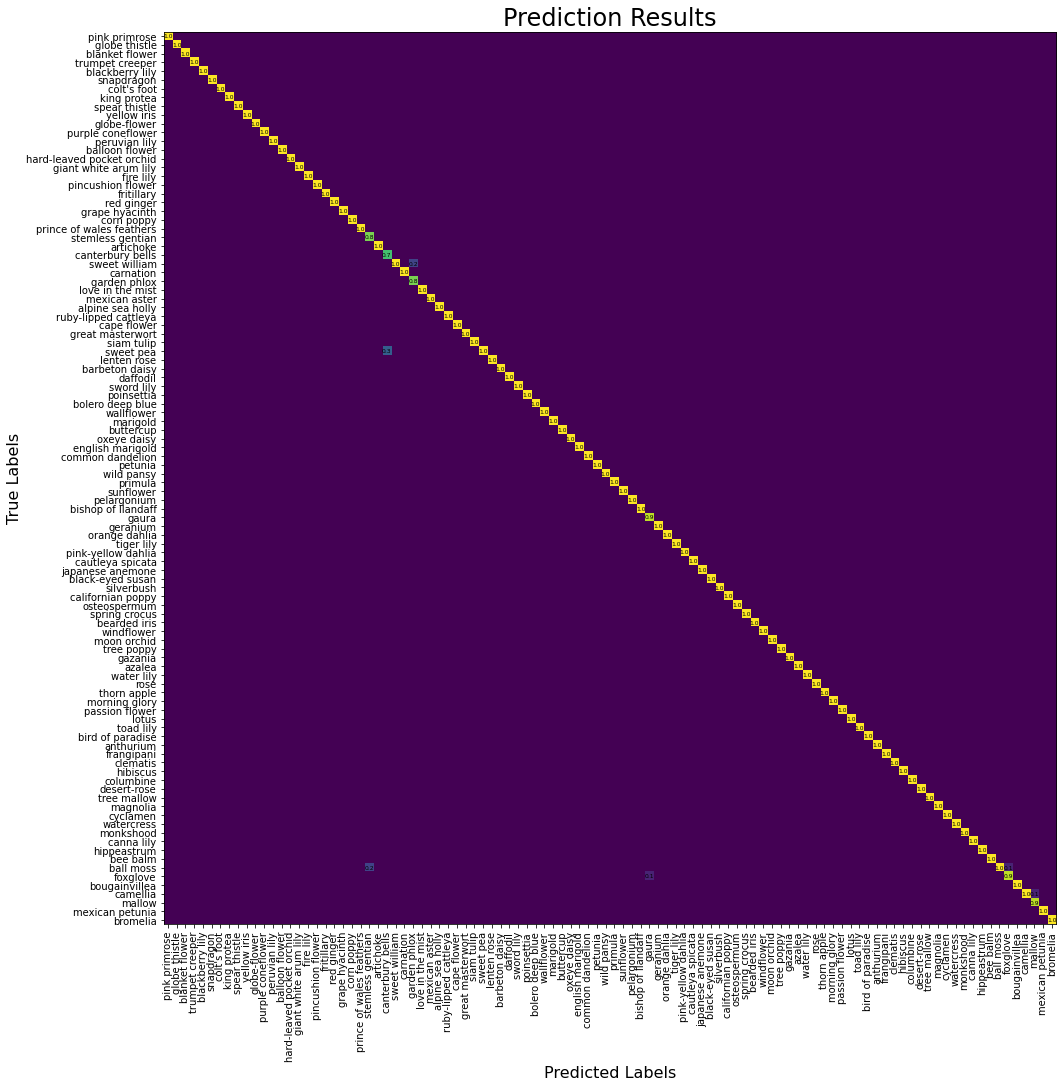

In [44]:
visualize_matrix(normalize_prediciton_matrix(prediction_matrix))

In [15]:
precision, recall, accuracy, f1_scores = np.zeros(NUM_CLASSES), np.zeros(NUM_CLASSES), np.zeros(NUM_CLASSES), np.zeros(NUM_CLASSES)
for i in range(NUM_CLASSES):
    precision[i] = prediction_matrix[i, i]  / np.sum(prediction_matrix[i, :])
    recall[i] = prediction_matrix[i, i] / np.sum(prediction_matrix[:, i])
    accuracy[i] = np.trace(prediction_matrix) / np.sum(prediction_matrix)
    f1_scores[i] = (2 * recall[i] * precision[i]) / (recall[i] + precision[i])

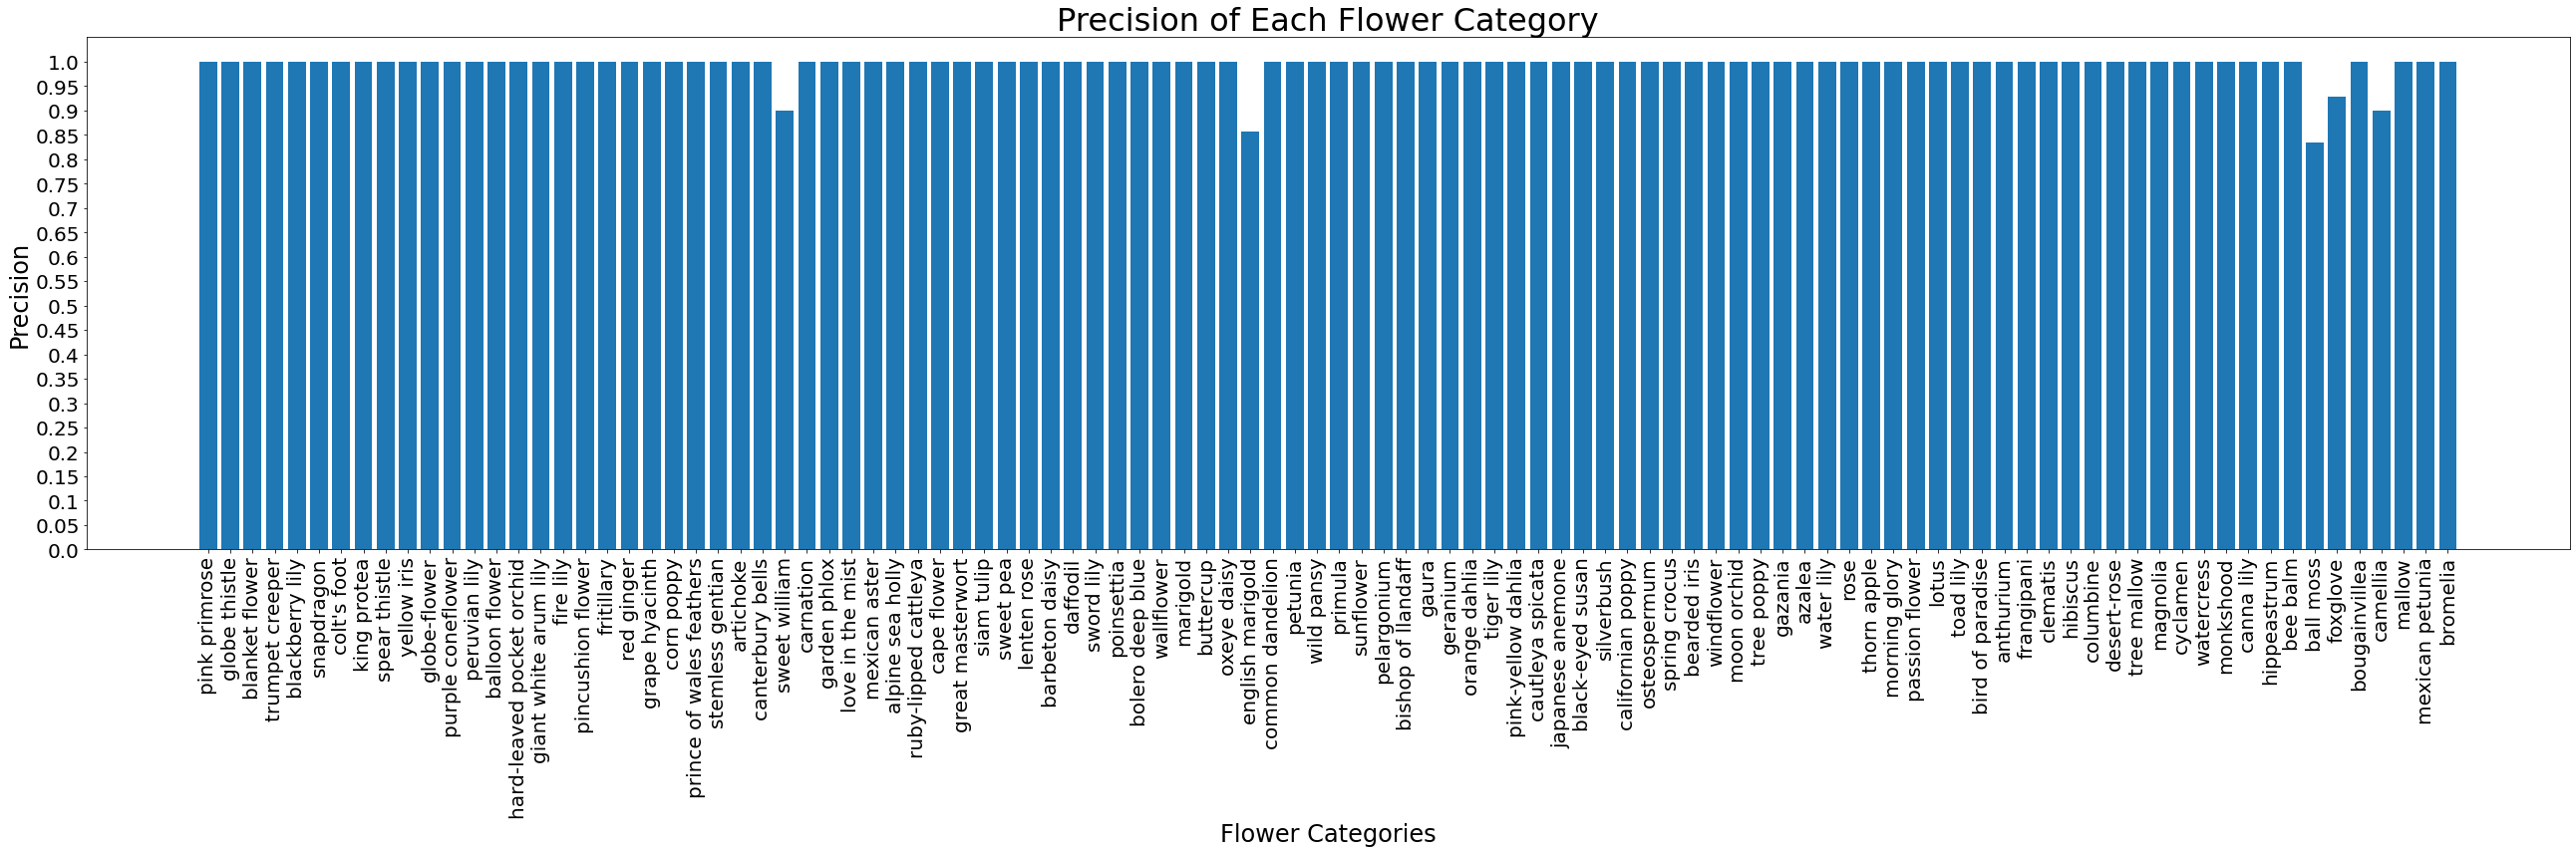

In [22]:
figure = plt.figure(figsize=(36, 12))
plt.xlabel("Flower Categories", fontsize=24)
plt.ylabel("Precision", fontsize=24)
plt.title("Precision of Each Flower Category", fontsize=32)
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=ordered_flower_names, rotation="vertical", fontsize=20)
plt.yticks(np.arange(21)/20, np.arange(21)/20, fontsize=20)
plt.bar(np.arange(NUM_CLASSES), precision)
plt.tight_layout()
plt.savefig("precision.png") 
plt.show()

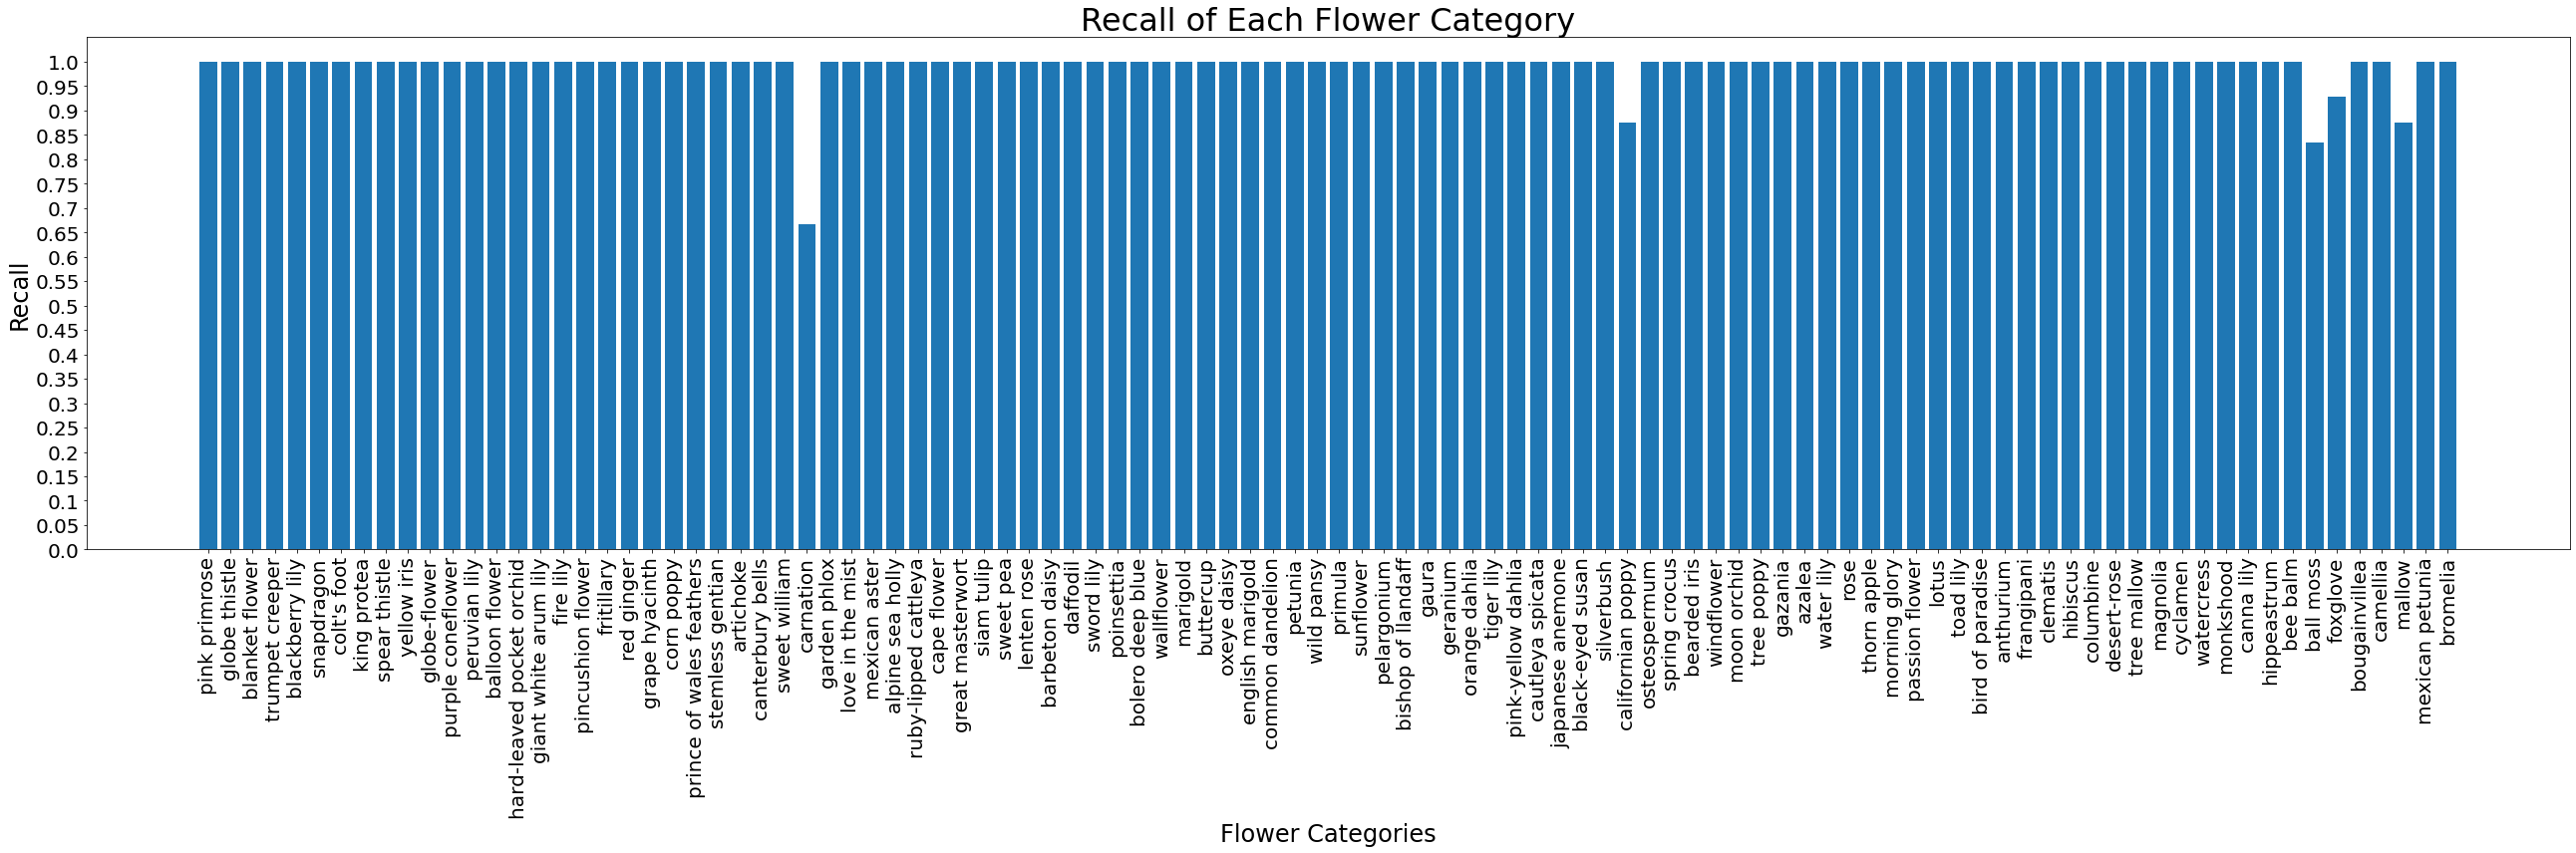

In [17]:
figure = plt.figure(figsize=(36, 12))
plt.xlabel("Flower Categories", fontsize=24)
plt.ylabel("Recall", fontsize=24)
plt.title("Recall of Each Flower Category", fontsize=32)
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=ordered_flower_names, rotation="vertical", fontsize=20)
plt.yticks(np.arange(21)/20, np.arange(21)/20, fontsize=20)
plt.bar(np.arange(NUM_CLASSES), recall)
plt.tight_layout()
plt.savefig("recall.png") 
plt.show()

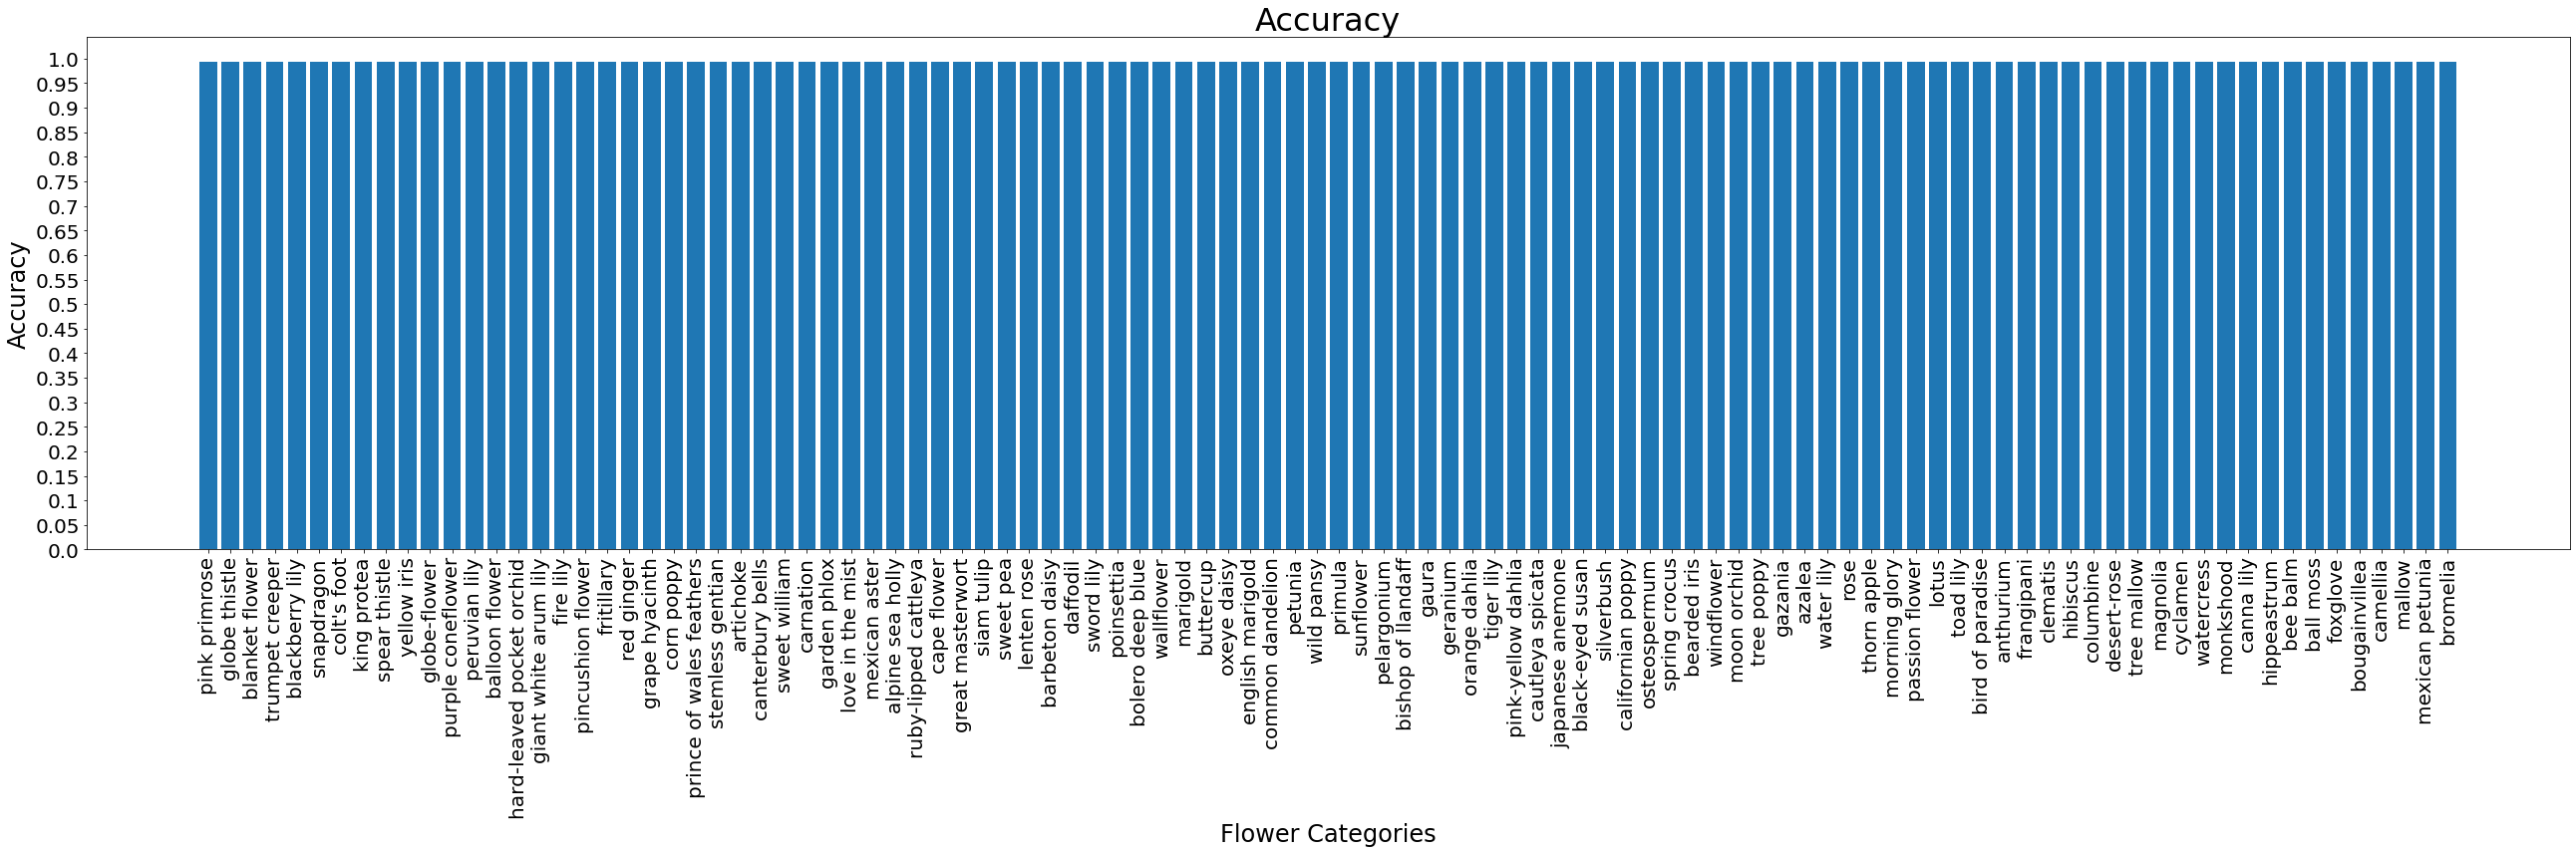

In [18]:
figure = plt.figure(figsize=(36, 12))
plt.xlabel("Flower Categories", fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.title("Accuracy", fontsize=32)
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=ordered_flower_names, rotation="vertical", fontsize=20)
plt.yticks(np.arange(21)/20, np.arange(21)/20, fontsize=20)
plt.bar(np.arange(NUM_CLASSES), accuracy)
plt.tight_layout()
plt.savefig("accuracy.png") 
plt.show()

In [19]:
print(accuracy)

[0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753
 0.99388753 0.99388753 0.99388753 0.99388753 0.99388753 0.9938

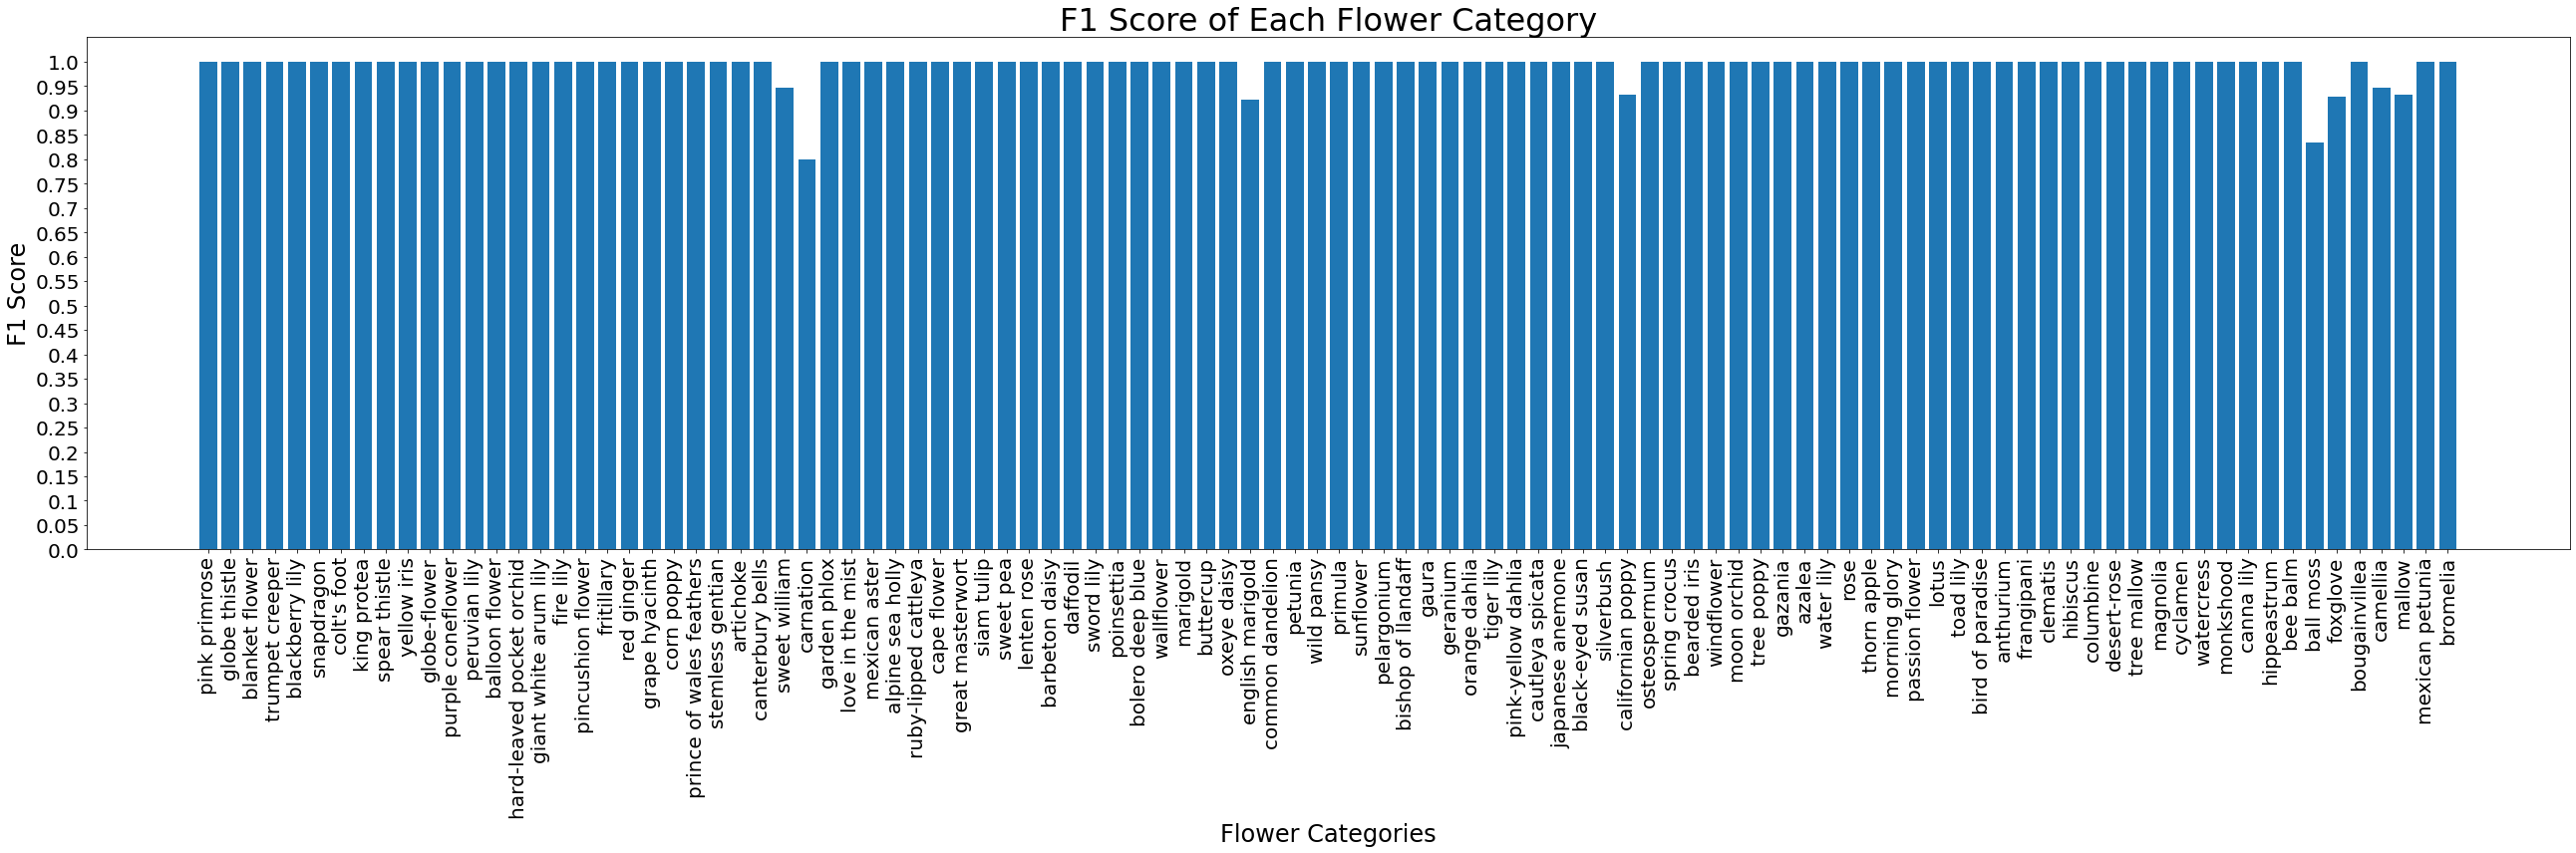

In [39]:
figure = plt.figure(figsize=(36, 12))
plt.xlabel("Flower Categories", fontsize=24)
plt.ylabel("F1 Score", fontsize=24)
plt.title("F1 Score of Each Flower Category", fontsize=32)
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=ordered_flower_names, rotation="vertical", fontsize=20)
plt.yticks(np.arange(21)/20, np.arange(21)/20, fontsize=20)
plt.bar(np.arange(NUM_CLASSES), f1_scores)
plt.tight_layout()
plt.savefig("f1_scores.png") 
plt.show()

In [19]:
# def visualize_matrix(matrix):
#     figure = plt.figure(figsize = (100, 100))
#     ax = plt.gca()
    
#     plt.rcParams['figure.figsize'] = (30, 30)
#     im = ax.matshow(matrix)
#     figure.colorbar(im)
#     ax.set_xticklabels("Predicted Labels", fontsize=64)
#     ax.set_yticklabels("True Labels", fontsize=64)
#     ax.set_title("Prediction Results", fontsize=24)
#     ax.set_xticks(ticks=np.arange(0, 102), labels=ordered_flower_names, rotation="vertical", fontsize=12)
#     ax.set_yticks(ticks=np.arange(0, 102), labels=ordered_flower_names, fontsize=12)
#     ax.xaxis.set_ticks_position("bottom")
    
#     for i in range(NUM_CLASSES):
#         for j in range(NUM_CLASSES):
#             if matrix[i, j] != 0:
#                 text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="w")
#     plt.show()